# ARIMA

Data needs to be stationary:
* remove variance — cox-box transformation that turns non-normally distributed data into normal distribution, `np.log()`
* remove trend — `.diff()`, `y(t)-y(t-1)` 
* remove seasonality — e.g. remove the monthly mean

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/flights_full.csv')

In [4]:
df = df[['passengers', 'trend_seasonal', 'remainder']]

<AxesSubplot:>

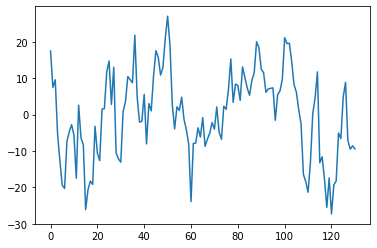

In [6]:
df['remainder'].plot()

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/Users/marija/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


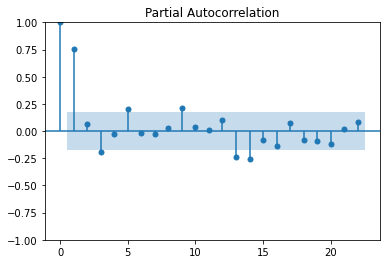

In [9]:
plot_pacf(df['remainder']);

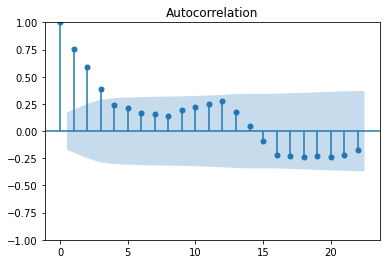

In [11]:
plot_acf(df['remainder']);

### AR with `statsmodels`

In [12]:
from statsmodels.tsa.ar_model import AutoReg

In [13]:
ar_model = AutoReg(endog=df['remainder'], lags=1).fit()

In [14]:
df['ar_prediction'] = ar_model.predict()

<ipython-input-14-74563b03c4dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ar_prediction'] = ar_model.predict()


<AxesSubplot:>

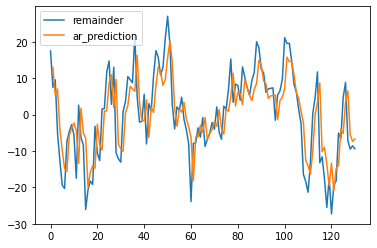

In [15]:
df[['remainder', 'ar_prediction']].plot()

In [16]:
df['full_prediction_ar'] = df['trend_seasonal'] + df['ar_prediction']

<ipython-input-16-209ee4b1b2a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_prediction_ar'] = df['trend_seasonal'] + df['ar_prediction']


<AxesSubplot:>

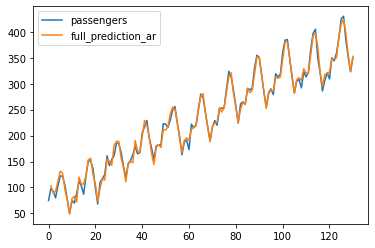

In [17]:
df[['passengers', 'full_prediction_ar']].plot()

### ARIMA

Can we do better than just the AR model?

**ARIMA(p, d, q)**

**AR(p)**
* autoregressive part
* value at point *t*, (linearly) depends on the value(s) in previous point(s) in time
* regression model on past values
* *p* is the number of lags to include; determined by looking at partial autocorrelation function plot (pacf)

**I(d)**
* time series is detrended by taking a difference between the current and previous point
* *d* is the order of differencing

**MA(q)**
* moving average part
* value at point *t*, (linearly) depends on the prediction errors in previous data points 
* regression model on past errors
* *q* is the number of lags to include; determined by looking at partial autocorrelation function plot (acf)

You can have a primarily AR process (q=0), a primarily MA process (p=0), or a more general ARMA (d=0) or ARIMA processes. 

p, q, d — ARIMA hyperparameters

### ARIMA with `statsmodels`

In [20]:
from statsmodels.tsa.arima.model import ARIMA

In [22]:
arima_model = ARIMA(df['remainder'], order=(1, 0, 1)).fit()

In [23]:
df['arima_prediction'] = arima_model.predict()

<ipython-input-23-c82c3093efe9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arima_prediction'] = arima_model.predict()


<AxesSubplot:>

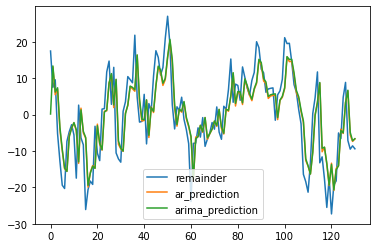

In [25]:
df[['remainder', 'ar_prediction', 'arima_prediction']].plot()

In [26]:
df['full_prediction_arima'] = df['trend_seasonal'] + df['arima_prediction']

<ipython-input-26-61d14cd1d818>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_prediction_arima'] = df['trend_seasonal'] + df['arima_prediction']


<AxesSubplot:>

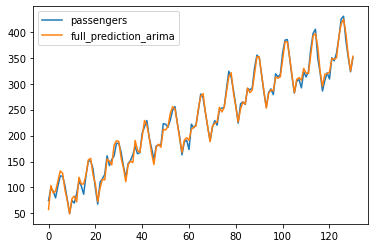

In [27]:
df[['passengers', 'full_prediction_arima']].plot()

### (auto)ARIMA/SARIMA with `pmdarima`

In [28]:
# !pip install pmdarima

In [29]:
import pmdarima as pm

In [42]:
m = pm.auto_arima(df['passengers'], 
                  seasonal=True, 
                  maxiter=10000, 
                  m=12, 
                  d=1,
                  D=1)

In [43]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  131
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -417.779
Date:                              Thu, 24 Feb 2022   AIC                            841.558
Time:                                      15:25:58   BIC                            849.870
Sample:                                           0   HQIC                           844.933
                                              - 131                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3131      0.076     -4.123      0.000      -0.462      -0.164
ma.S.L12      -0.4957      0.093     -5.348      0.000      -0.677      -0.314
sigma2        67.5974      8.585      7.874      0.000      50.770      84.424
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.27
Prob(Q):                              0.97   Prob(JB):                         0.87
Heteroskedasticity (H):               0.46   Skew:                             0.07
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
df['full_prediction_autoarima'] = m.predict_in_sample()

<ipython-input-44-3118e1aac264>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_prediction_autoarima'] = m.predict_in_sample()


<AxesSubplot:>

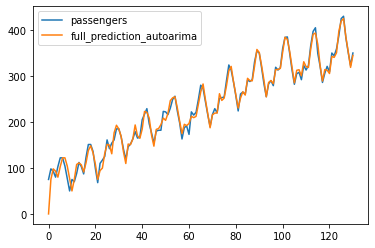

In [45]:
df[['passengers', 'full_prediction_autoarima']].plot()

In [46]:
y_forecast, ci = m.predict(12, return_conf_int=True)

In [47]:
y_forecast

array([358.71480414, 346.90644309, 384.2348871 , 377.665102  ,
       388.66470893, 423.72375042, 456.10738983, 460.10275928,
       414.32191251, 382.86076622, 352.59602754, 377.6966128 ])

In [50]:
timestamp = np.arange(len(df) + len(y_forecast))

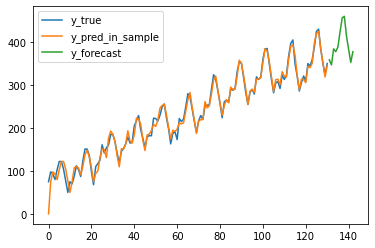

In [52]:
plt.plot(timestamp[:len(df)], df['passengers'], label='y_true')
plt.plot(timestamp[:len(df)], df['full_prediction_autoarima'], label='y_pred_in_sample')
plt.plot(timestamp[len(df):], y_forecast, label='y_forecast')
plt.legend()

Interesting things to try:
* predict for longer in the future
* change some of the sARIMA hyperparameters and see how predictions change
* plot confidence intervals